Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.

Warning! Using mpiexec in global path
Warning! Using python in global path


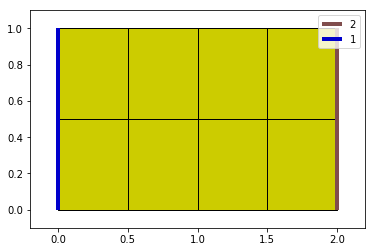

In [1]:
import amfe
import matplotlib.pyplot as plt
import pandas as pd
import scipy.linalg as linalg
from scipy.sparse import linalg as splinalg
import numpy as np

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
#%matplotlib notebook

mshfile = amfe.amfe_dir('meshes/test_meshes/2_partitions_quad_mesh.msh')
#mshfile = amfe.amfe_dir('meshes/test_meshes/3_partition_2d_blade_quad_mesh.msh')

m = amfe.Mesh()
m.import_msh(mshfile)



amfe.plot_mesh(m)
plt.show()

In [2]:
my_comp = amfe.CraigBamptonComponent()
my_comp.set_mesh_obj(m)

my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)
#domain = m.set_domain('phys_group', 3)
#domain.set_material(my_material)


my_comp.set_domain(3,my_material)

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 8 elements and 30 dofs.
Time taken for preallocation: 0.00 seconds.


In [3]:
my_comp.apply_neumann_boundaries(2,1e8, 'normal')
K, f = my_comp.assembly_class.assemble_k_and_f()
K_, f = my_comp.assembly_class.assemble_k_and_f_neumann()
M = my_comp.assembly_class.assemble_m()


In [4]:

def get_dirichlet_dofs(submesh_obj,direction ='xyz',id_matrix=None):
    
    x_dir = 0
    y_dir = 1
    z_dir = 2
    
    dofs_to_keep = []
    if 'x' in direction:
        dofs_to_keep.append(x_dir)

    if 'y' in direction:
        dofs_to_keep.append(y_dir)
    
    if 'z' in direction:
        dofs_to_keep.append(z_dir)
    
    
    
    dir_nodes = submesh_obj.global_node_list
    
    dir_dofs = []
    for node, dofs in id_matrix.items():
        if node in dir_nodes:
            local_dofs = []
            for i in dofs_to_keep:
                try:
                    local_dofs.append(dofs[i])
                except:
                    print('It is not possible to issert dof %i as dirichlet dof' %i)
            dir_dofs.extend(local_dofs)
    return dir_dofs


dirsub = m.get_submesh('phys_group', 1)
dirsub2 = m.get_submesh('phys_group', 2)

id_matrix = my_comp.assembly_class.id_matrix
dir_dofs = get_dirichlet_dofs(dirsub, direction ='xyz', id_matrix=id_matrix)
dir_dofs_2 = get_dirichlet_dofs(dirsub2, direction ='x', id_matrix=id_matrix)

K, M, f = my_comp.insert_dirichlet_boundary_cond(K,M,f,dir_dofs, value = 0.0)


K, M, f = my_comp.insert_dirichlet_boundary_cond(K,M,f,dir_dofs_2, value = 1.0)

print(my_comp.check_symmetry(K))

u = splinalg.spsolve(K,f)



print(u[dir_dofs])
print(u[dir_dofs_2])
my_comp.u_output.append(0.0*u)
my_comp.u_output.append(u)


It is not possible to issert dof 2 as dirichlet dof
It is not possible to issert dof 2 as dirichlet dof
It is not possible to issert dof 2 as dirichlet dof
Dirichlet boundary with generate a non-symetric Stiffness Matrix
False
[ 0.  0.  0.  0.  0.  0.]
[ 1.0025  1.0025  1.005 ]


C:\Users\ndcsi\.conda\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


In [7]:
@interact(scale=(0,5,0.1))   
def plot(scale):
    amfe.plot_system_solution(my_comp,factor=scale)
    plt.show()

interactive(children=(FloatSlider(value=2.0, description='scale', max=5.0), Output()), _dom_classes=('widget-i…